In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib notebook

from Document import Document
from ParserCACM import ParserCACM
from ParserQuery import QueryParser, Query
from porter import stem
from TextRepresenter import PorterStemmer
from Index import Index, InvertedIndexPlaces
from Weighter import *
from IRModel import Vectoriel, LanguageModel, BM25Model, LinearMetaModel
from Featurer import Featurer

from Evaluation import IRList, PrecisionRecallEval
from EvalIRModel import EvalIRModel

__Modèles étudiés :__  
Vectoriel weighter 1 (booléen)  
Vectoriel weighter 2 (tf)  
Vectoriel weighter 3 (tf doc, idf query)  
Language Model (weighters 2)  
BM25 (weighter 2)  
Metamodel  

## Configuration des modèles
### Historique GridSearch des meilleurs paramètres

In [25]:
with open('models/lang_results_corrected_cacm_w2.pickle', 'rb') as f:
    lang_cacm_results = pickle.load(f)

In [3]:
with open('models/lang_results_cisi_w2.pickle', 'rb') as f:
    lang_cisi_results = pickle.load(f)

In [4]:
with open('models/bm25_results_cacm_w2.pickle', 'rb') as f:
    bm25_cacm_results = pickle.load(f)

In [5]:
with open('models/bm25_results_cisi_w2.pickle', 'rb') as f:
    bm25_cisi_results = pickle.load(f)

Meilleur lambda : 0.15789473684210525 , précision moyenne : 0.18396040729878854


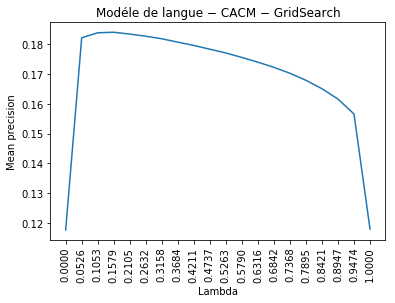

In [28]:
#lambda_values = np.linspace(0,1,100)
plt.figure()
lambda_values = np.linspace(1e-5, 1, 20)
plt.title("Modéle de langue − CACM − GridSearch")
plt.xlabel("Lambda")
plt.ylabel('Mean precision')
plt.plot(lambda_values, lang_cacm_results[:,1])
plt.xlabel("Lambda")
plt.xticks(lambda_values, rotation='vertical');


idx = np.argmax(lang_cacm_results[:, 1])
print("Meilleur lambda :", lang_cacm_results[idx, 0]['lambd'], ', précision moyenne :', lang_cacm_results[idx, 1])

Meilleur lambda : 1e-05 , précision moyenne : 0.05716553186083271


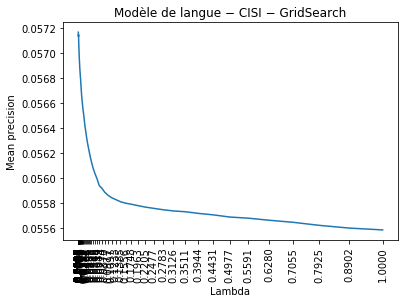

In [7]:
#lambda_values = np.linspace(0,1,100)
plt.figure()
lambda_values = np.geomspace(1e-5, 1, 100)
plt.title("Modèle de langue − CISI − GridSearch")
plt.xlabel("Lambda")
plt.ylabel('Mean precision')
plt.plot(lambda_values, lang_cisi_results[:,1])
plt.xlabel("Lambda")
plt.xticks(lambda_values, rotation='vertical');


idx = np.argmax(lang_cisi_results[:, 1])
print("Meilleur lambda :", lang_cisi_results[idx, 0]['lambd'], ', précision moyenne :', lang_cisi_results[idx, 1])

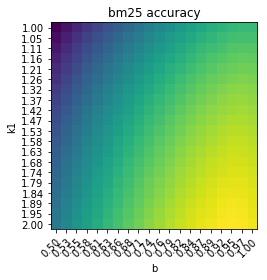

Meilleur k1 : 2.0 , meilleur b : 0.9473684210526315 , précision moyenne : 0.2145680542947729


In [8]:
param_a_values = np.linspace(1, 2, 20)
param_b_values = list(np.linspace(0.5, 1, 20))
bm25_matrix = np.array(bm25_cacm_results[:, 1].reshape(20, 20), dtype=np.float)
# k1 : ligne, b : colonnes

fig, ax = plt.subplots()
im = ax.imshow(bm25_matrix)
plt.xlabel("b")
plt.ylabel('k1')
# We want to show all ticks...
ax.set_xticks(np.arange(len(param_b_values)))
ax.set_yticks(np.arange(len(param_a_values)))
# ... and label them with the respective list entries
ax.set_xticklabels(['{:.2f}'.format(k1v) for k1v in param_b_values])
ax.set_yticklabels(['{:.2f}'.format(k1v) for k1v in param_a_values])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("bm25 accuracy")
#fmt = StrMethodFormatter('{x}')
#ax.yaxis.set_major_formatter(fmt)

fig.tight_layout()
plt.show()

idx = np.argmax(bm25_matrix)
print("Meilleur k1 :", param_a_values[idx//20], ", meilleur b :", param_b_values[idx%20],
      ", précision moyenne :", np.max(bm25_matrix))

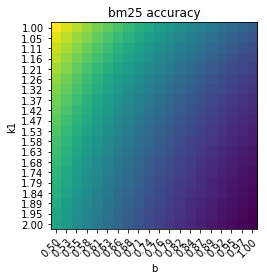

Meilleur k1 : 1.0 , meilleur b : 0.5 , précision moyenne : 0.05532735502709977


In [9]:
param_a_values = np.linspace(1, 2, 20)
param_b_values = list(np.linspace(0.5, 1, 20))
bm25_matrix = np.array(bm25_cisi_results[:, 1].reshape(20, 20), dtype=np.float)
# k1 : ligne, b : colonnes

fig, ax = plt.subplots()
im = ax.imshow(bm25_matrix)
plt.xlabel("b")
plt.ylabel('k1')
# We want to show all ticks...
ax.set_xticks(np.arange(len(param_b_values)))
ax.set_yticks(np.arange(len(param_a_values)))
# ... and label them with the respective list entries
ax.set_xticklabels(['{:.2f}'.format(k1v) for k1v in param_b_values])
ax.set_yticklabels(['{:.2f}'.format(k1v) for k1v in param_a_values])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("bm25 accuracy")
#fmt = StrMethodFormatter('{x}')
#ax.yaxis.set_major_formatter(fmt)

fig.tight_layout()
plt.show()

idx = np.argmax(bm25_matrix)
print("Meilleur k1 :", param_a_values[idx//20], ", meilleur b :", param_b_values[idx%20],
      ", précision moyenne :", np.max(bm25_matrix))

### Création des modèles sur CACM

In [18]:
index = Index("cacm", "cacm/cacm.txt")
#index.indexation()

weighter1 = WeighterBoolean(index)
weighter2 = WeighterVector(index)
weighter3 = WeighterSchema3(index)

models = {}
models["vectoriel_w1"] = Vectoriel(weighter1)
models["vectoriel_w2"] = Vectoriel(weighter2)
models['vectoriel_w3'] = Vectoriel(weighter3)
models['lang'] = LanguageModel(weighter2)
models["bm25"] = BM25Model(weighter2)
models["meta"] = LinearMetaModel(Featurer(index))
model_names = list(models.keys())

precalcul features


In [29]:
# lang 
lambd = 0.158
# bm25
k1 = 2
b = 0.95
# LinearMetaModel
models["meta"].load_weights()

# Evaluation sur CACM

In [36]:
train_prop = 0.8
seed = 42
train_results = {}
test_results = {}

In [37]:

train_results['vectoriel_w1'] = EvalIRModel().evalModel(models['vectoriel_w1'],
                                                     train_prop=train_prop, seed=seed, mode='train')
train_results['vectoriel_w2'] = EvalIRModel().evalModel(models['vectoriel_w2'],
                                                     train_prop=train_prop, seed=seed, mode='train')
train_results['vectoriel_w3'] = EvalIRModel().evalModel(models['vectoriel_w3'],
                                                     train_prop=train_prop, seed=seed, mode='train')

train_results['lang'] = EvalIRModel().evalModel(models['lang'],
                                               ranking_call = lambda m, q: m.getRanking(q, lambd=lambd),
                                               train_prop=train_prop, seed=seed, mode='train')
train_results['bm25'] = EvalIRModel().evalModel(models["bm25"],
                                                ranking_call = lambda m,q : m.getRanking(q, k1=k1, b=b),
                                               train_prop=train_prop, seed=seed, mode='train')
train_results['meta'] = EvalIRModel().evalModel(models["meta"], train_prop=train_prop, seed=seed, mode='train')

/home/pierre/documents/upmc/ri/git/IRModel.py:97: RuntimeWarning: divide by zero encountered in log
  scores[d] += tw4q[stem] * np.log((1-lambd)*(tf_t_c/l_c))


In [38]:
test_results['vectoriel_w1'] = EvalIRModel().evalModel(models['vectoriel_w1'],
                                                     train_prop=train_prop, seed=seed, mode='test')
test_results['vectoriel_w2'] = EvalIRModel().evalModel(models['vectoriel_w2'],
                                                     train_prop=train_prop, seed=seed, mode='test')
test_results['vectoriel_w3'] = EvalIRModel().evalModel(models['vectoriel_w3'],
                                                     train_prop=train_prop, seed=seed, mode='test')

test_results['lang'] = EvalIRModel().evalModel(models['lang'],
                                               ranking_call = lambda m, q: m.getRanking(q, lambd=lambd),
                                               train_prop=train_prop, seed=seed, mode='test')
test_results['bm25'] = EvalIRModel().evalModel(models["bm25"],
                                                ranking_call = lambda m,q : m.getRanking(q, k1=k1, b=b),
                                               train_prop=train_prop, seed=seed, mode='test')
test_results['meta'] = EvalIRModel().evalModel(models["meta"], train_prop=train_prop, seed=seed, mode='test')

/home/pierre/documents/upmc/ri/git/IRModel.py:97: RuntimeWarning: divide by zero encountered in log
  scores[d] += tw4q[stem] * np.log((1-lambd)*(tf_t_c/l_c))


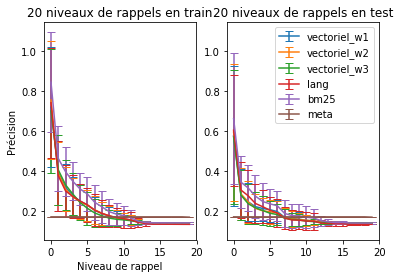

In [39]:
fig = plt.figure()
legend = []

ax1 = fig.add_subplot(1, 2, 1)
plt.title("20 niveaux de rappels en train")
for model_name, model_results in train_results.items():
    legend.append(model_name)
    plt.errorbar(range(20), model_results['precision_recall'], yerr=model_results['precision_recall_std'], capsize=4)

plt.xlabel("Niveau de rappel")
plt.ylabel("Précision")
    
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
plt.title('20 niveaux de rappels en test')
for model_name, model_results in test_results.items():
    ax2.errorbar(range(20), model_results['precision_recall'], yerr=model_results['precision_recall_std'], capsize=4)
  
    
plt.legend(legend)
plt.show()

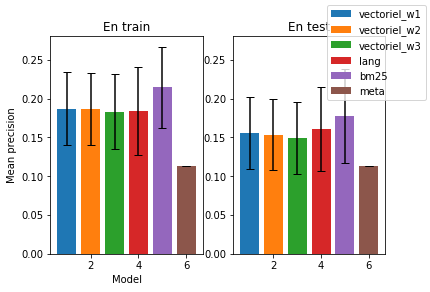

In [40]:
fig = plt.figure()
legend = []

ax1 = fig.add_subplot(1, 2, 1)
plt.title('En train')
i = 0
for model_name, model_results in train_results.items():
    legend.append(model_name)
    i += 1
    ax1.bar(i, model_results['precision_mean'], yerr=model_results['precision_mean_std'], capsize=4)
    
plt.xlabel('Model')
plt.ylabel('Mean precision')

ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
plt.title('En test')
i = 0
for model_name, model_results in test_results.items():
    i += 1
    ax2.bar(i, model_results['precision_mean'], yerr=model_results['precision_mean_std'], capsize=4)

fig.legend(legend)
plt.show()

We can see, that Meta model does not perform very vell compared to BM25 model. In the training of the metamodel, we did not consider the evaluation scores (only the loss that do depelop nicely), so the problem might be overfitting. Results are consistent between precision−recall and average precision. There is probably mistakes in our language and meta models.